# Genetic Algorithm for Finding the Optimal Neural Network Weights

## Imports

In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data preparation

In [2]:
# Load the iris dataset.
iris = load_iris()
X: np.ndarray = iris.data
y: np.ndarray = iris.target

In [3]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
# Scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
X_train: torch.Tensor = torch.from_numpy(X_train).float()
X_test: torch.Tensor = torch.from_numpy(X_test).float()
y_train: torch.Tensor = torch.from_numpy(y_train).long()
y_test: torch.Tensor = torch.from_numpy(y_test).long()

In [10]:
# Create the 'models' directory.
models_path = Path("models")
models_path.mkdir(exist_ok=True)

## Model definition

In [55]:
# Create the model.
iris_model = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.Softmax(dim=1)
)

In [7]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()

In [23]:
# Evaluate the model.
def calculate_metrics(x: torch.Tensor, yt: torch.Tensor) -> None:
    # Calculate the crossentropy loss of the trained model.
    with torch.no_grad():
        preds = iris_model(x)
        loss = criterion(preds, yt).item()
    print(f"Crossentropy : {loss}")
    # Calculate the classification accuracy for the trained model.
    acc = torch.mean((torch.argmax(preds, dim=1) == yt).float()).item()
    print(f"Accuracy : {acc}")

## Implementation using our own Genetic Algorithm

In [9]:
from genalg import GeneticAlgorithm, ModelParams

In [21]:
# Move the model and data to the GPU.
iris_model = iris_model.cuda()
X_train = X_train.cuda()
y_train = y_train.cuda()
X_test = X_test.cuda()
y_test = y_test.cuda()

In [11]:
def load_params(model: nn.Module, params: ModelParams) -> None:
    model_params = model.state_dict()
    model_params['0.weight'] = torch.FloatTensor(params[:40].reshape(10, 4))
    model_params['0.bias'] = torch.FloatTensor(params[40:50])
    model_params['2.weight'] = torch.FloatTensor(params[50:80].reshape(3, 10))
    model_params['2.bias'] = torch.FloatTensor(params[80:])
    model.load_state_dict(model_params)

In [12]:
def on_generation(generation: int, scores: list[float]) -> None:
    print(
        f"Generation: {generation:0=3} "
        f"Best fitness: {np.max(scores):.10f} "
        f"Average fitness: {np.mean(scores):.10f} "
        f"Worst fitness: {np.min(scores):.10f}"
    )

In [13]:
def fitness_fn(solution: ModelParams) -> float:
    load_params(iris_model, solution)
    with torch.no_grad():
        outputs = iris_model(X_train)
        loss: torch.Tensor = criterion(outputs, y_train)
        fitness = 1.0 / (loss.detach().item() + 1e-8)
    return fitness

In [39]:
# Create the GA instance
ga = GeneticAlgorithm(
    model=iris_model,
    population_size=30,
    num_generations=600,
    neuron_off_rate=1e-4,
    mutation_rate=0.05,
    elitism=True,
    fitness_fn=fitness_fn,
    on_generation=on_generation,
    on_generation_interval=50,
)

In [40]:
# Run the algorithm
ga.run()

Generation: 000 Best fitness: 1.1910996178 Average fitness: 0.9075365693 Worst fitness: 0.7141730377
Generation: 050 Best fitness: 1.1869424708 Average fitness: 1.0946339582 Worst fitness: 1.0085564687
Generation: 100 Best fitness: 1.4060704523 Average fitness: 1.3660223027 Worst fitness: 1.3299100653
Generation: 150 Best fitness: 1.4639450473 Average fitness: 1.4089416744 Worst fitness: 1.3587771707
Generation: 200 Best fitness: 1.4542243131 Average fitness: 1.4344275882 Worst fitness: 1.4161880411
Generation: 250 Best fitness: 1.5399362410 Average fitness: 1.5061239353 Worst fitness: 1.4721380811
Generation: 300 Best fitness: 1.5927851882 Average fitness: 1.5457220182 Worst fitness: 1.5042679027
Generation: 350 Best fitness: 1.6186647513 Average fitness: 1.5902067086 Worst fitness: 1.4920770500
Generation: 400 Best fitness: 1.6285815668 Average fitness: 1.6057169204 Worst fitness: 1.5813101976
Generation: 450 Best fitness: 1.6580407938 Average fitness: 1.6345811051 Worst fitness: 1.5

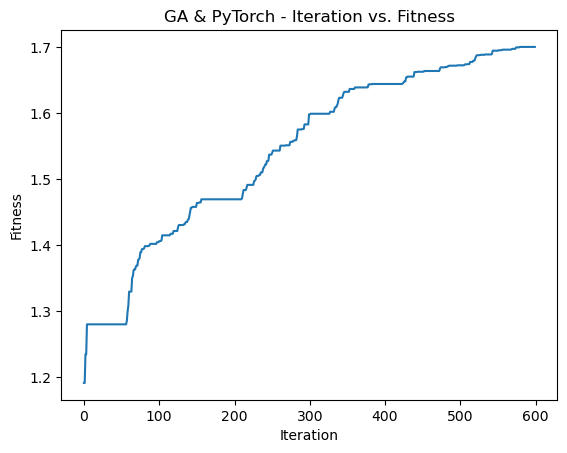

In [41]:
# Plot the fitness curve.
ga.plot_fitness()

In [ ]:
# Print GA summary.
ga.print_summary()

In [ ]:
# Load the weights of the best solution into the model.
best_solution = ga.best_solution
load_params(iris_model, best_solution)

In [27]:
# Define the path to save the model weights.
weights_path = models_path / "ga_weights.pth"

In [28]:
# Load model weights into the model.
iris_model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [29]:
# Calculate the metrics of the best solution.
print("On the training set:")
calculate_metrics(X_train, y_train)
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the training set:
Crossentropy : 0.5931076407432556
Accuracy : 0.9629629254341125
On the testing set:
Crossentropy : 0.5830239057540894
Accuracy : 1.0


In [50]:
# Save the model weights.
torch.save(iris_model.state_dict(), weights_path)

## Implementation using PyGAD library

In [30]:
import pygad
import pygad.torchga as torchga

In [31]:
# Move the model and data to the CPU.
iris_model = iris_model.cpu()
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

In [56]:
# Define the parameters.
sol_per_pop = 10
num_generations = 100

In [57]:
# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(
    model=iris_model,
    num_solutions=sol_per_pop,
)

In [58]:
# Some parameters are initialized within the constructor.
initial_population = torch_ga.population_weights

In [59]:
# Define the fitness function for classification.
def fitness_func(_ga: pygad.GA, sol: np.ndarray, _sol_idx: int) -> float:
    preds = torchga.predict(model=iris_model,
                            solution=sol,
                            data=X_train)
    fitness = 1.0 / (criterion(preds, y_train).detach().numpy() + 1e-8)
    return fitness

In [60]:
# Define the callback function.
# noinspection PyShadowingNames
def on_generation(ga: pygad.GA) -> None:
    print(f'Gen#{ga.generations_completed:0=2}, Fitness: {ga.best_solution()[1]}')

In [61]:
# Create an instance of the GA class inside the ga module.
ga = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=sol_per_pop // 2,
    initial_population=initial_population,
    fitness_func=fitness_func,
    on_generation=on_generation,
)

In [62]:
# Run the genetic algorithm.
ga.run()

Gen#01, Fitness: 1.021122908438827
Gen#02, Fitness: 1.1075730838433375
Gen#03, Fitness: 1.1075730838433375
Gen#04, Fitness: 1.1842352415120814
Gen#05, Fitness: 1.249055108734468
Gen#06, Fitness: 1.3113565029643597
Gen#07, Fitness: 1.3194216717108271
Gen#08, Fitness: 1.3492426519924894
Gen#09, Fitness: 1.3492426519924894
Gen#10, Fitness: 1.3492426519924894
Gen#11, Fitness: 1.3886057960515175
Gen#12, Fitness: 1.3886057960515175
Gen#13, Fitness: 1.3953111566159564
Gen#14, Fitness: 1.4067320839112836
Gen#15, Fitness: 1.4623186717801957
Gen#16, Fitness: 1.463034821607316
Gen#17, Fitness: 1.463034821607316
Gen#18, Fitness: 1.4671656925200995
Gen#19, Fitness: 1.4900372304699445
Gen#20, Fitness: 1.4900372304699445
Gen#21, Fitness: 1.4900372304699445
Gen#22, Fitness: 1.526115574498242
Gen#23, Fitness: 1.526115574498242
Gen#24, Fitness: 1.5421611378431195
Gen#25, Fitness: 1.546795255187125
Gen#26, Fitness: 1.546795255187125
Gen#27, Fitness: 1.590113476289419
Gen#28, Fitness: 1.590113476289419
Ge

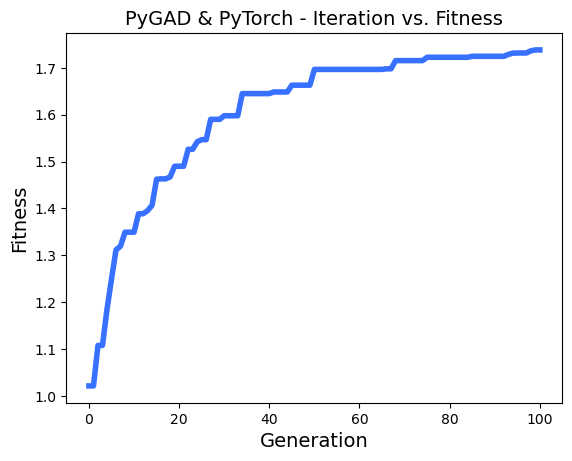

In [63]:
# After the generations complete, some plots are shown that summarize
# how the outputs/fitness values evolve over generations.
_ = ga.plot_fitness(
    title="PyGAD & PyTorch - Iteration vs. Fitness",
    linewidth=4
)

In [64]:
# Returning the details of the best solution.
best_solution, best_solution_fitness, best_solution_idx = ga.best_solution()
print(f"Fitness value of the best solution = {best_solution_fitness}")
print(f"Index of the best solution : {best_solution_idx}")

Fitness value of the best solution = 1.7382707560833057
Index of the best solution : 0


In [65]:
# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(
    model=iris_model,
    weights_vector=best_solution
)
iris_model.load_state_dict(best_solution_weights)

<All keys matched successfully>

In [66]:
print("On the training set:")
calculate_metrics(X_train, y_train)
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the training set:
Crossentropy : 0.5752843618392944
Accuracy : 0.9777777791023254
On the testing set:
Crossentropy : 0.5660752058029175
Accuracy : 1.0


In [67]:
# Save the model weights.
weights_path = models_path / "pygad_weights.pth"
torch.save(iris_model.state_dict(), weights_path)